In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from src.data import process_mda_structures
from src.plotting import colour_gradient
plt.style.use('plot.mplstyle')
from ase.io import read

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evolution of Steinhardt parameters over LDA compression

We look at how the values of the individual Steinhardt parameters change as a function of pressure (Fig. 4 & Fig. S5).

In [3]:
# Get an average steinhardt vector for MDA 
# averaged across all 5 runs

mda_steinhardt = process_mda_structures(all_runs=True)

mda_av_steinhardt = {}
mda_stds = {}
for struct_type, steinhardts in mda_steinhardt.items():
    mda_av_steinhardt[struct_type] = np.mean(steinhardts, axis=0)
    
AVG_MDA_STEINHARDT_VECTOR = mda_av_steinhardt['mda']

In [6]:
temp = 100

pressures =np.arange(100, 20_001, 100)

all_atom_descriptors = {} # a dict of pressure to a np.array of shape (n_structures, n_atoms, n_descriptors)
for p in pressures:
    # each pressure has 10 structures
    file_name = f"../data/compression_{temp}K/compression_pressure{p}.extxyz"
    structures = read(file_name, index=':')

    descriptors = []
    for s in structures:
        descriptors.append(s.arrays["steinhardt_descriptor"])
    
    # all descriptors for all 10 structures for a given pressure
    all_atom_descriptors[p] = np.array(descriptors)

In [7]:
from sklearn.preprocessing import StandardScaler

# standardise the Steinhardt vector, with per-feature mean and std
# as calculated over all atoms from all structures in the compression trajectory

transform = StandardScaler()

all_descriptors = np.vstack(np.vstack(list(all_atom_descriptors.values())))
transform.fit(all_descriptors)

StandardScaler()

In [8]:
# standardize the average mda steinhardt vector
std_mda_vector = transform.transform(AVG_MDA_STEINHARDT_VECTOR.reshape(1, -1)).reshape(-1)

distances = []
for p, descriptors in all_atom_descriptors.items():
    # stack all the descriptors for this pressure
    stacked_descriptors = np.vstack(descriptors)
    # standardise the descriptors
    standardized_descriptors = transform.transform(stacked_descriptors)
    
    # get the rmsd between the average mda descriptor and the
    # average descriptor for this pressure
    per_atom_distance = np.linalg.norm(
        standardized_descriptors.mean(axis=0) - std_mda_vector,
    )
    distances.append(per_atom_distance)

In [14]:
# find the pressure where the average descriptor is most similar to the mda descriptor
# i.e. the themodynamic conditions where MDA is most similar to another state

all_pressures = np.array(list(all_atom_descriptors.keys()))
most_similar_idx = np.argmin(distances)

print(f"Most similar pressure: {all_pressures[most_similar_idx]/10000}0 GPa")

Most similar pressure: 0.720 GPa


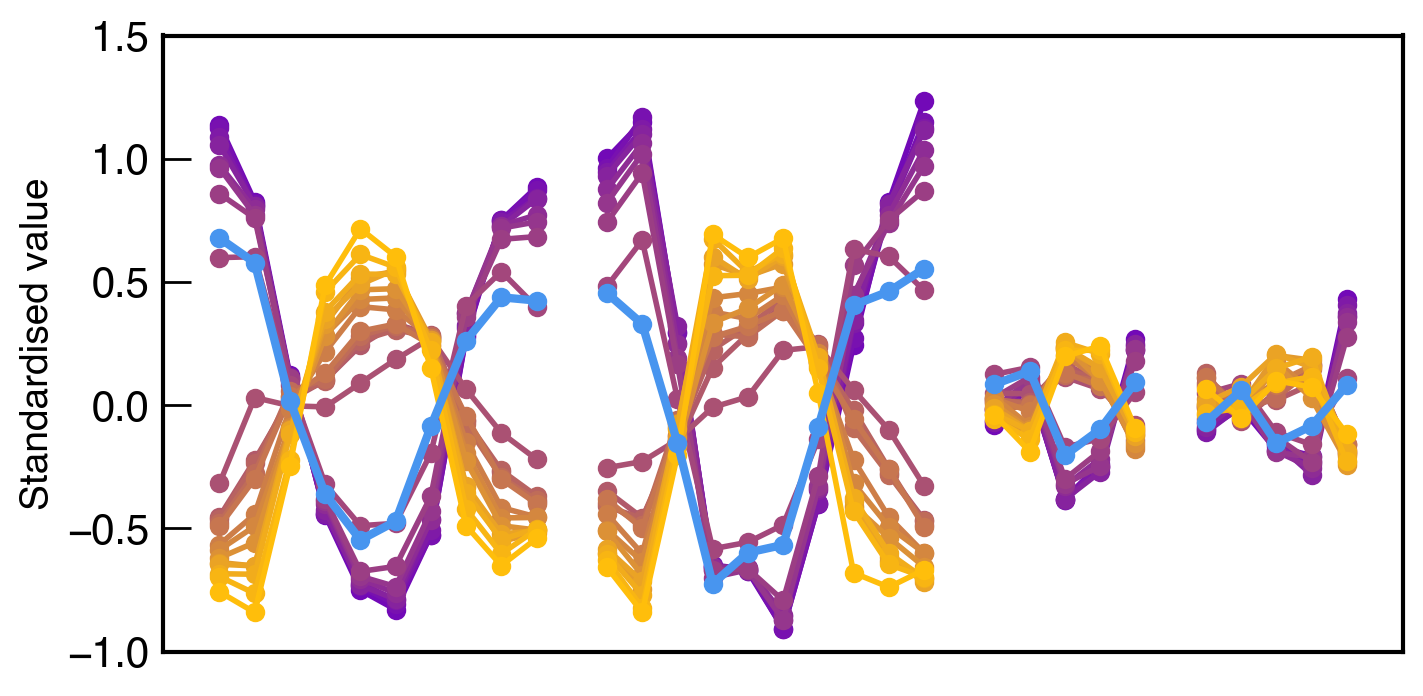

In [16]:
mda_color = '#4895ef'
hda_color = '#ffbe0b'
lda_color = '#7209b7'
pressure_colours = list(colour_gradient(all_pressures, lda_color, hda_color))

def plot_pressure(p):
    # the pressures to plot
    # graph is too busy if we plot all pressures
    return p % 1000 == 0 or p == 100

# disconnect the plot at these points
start_stops = [(0, 10), (10, 20), (20, 25), (25, 30)]
spacing = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for i, (pressure, colour) in enumerate(pressure_colours):
    if not plot_pressure(pressure):
        continue
    
    # get the average steinhardt descriptor for this pressure
    avg_steinhardt = np.mean(np.vstack(all_atom_descriptors[pressure]), axis=0)
    # standardize
    standardized_descriptors = transform.transform(avg_steinhardt.reshape(1, -1)).reshape(-1)
    
    for x, (start, stop) in enumerate(start_stops):
        ax.plot(
            np.arange(start + x*spacing, stop+x*spacing),
            standardized_descriptors[start:stop],
            "-o",
            color=colour,
            linewidth=2,
        )
        
# plot the mda structure
for x, (start, stop) in enumerate(start_stops):
    ax.plot(
        np.arange(start + x*spacing, stop+x*spacing),
        std_mda_vector[start:stop],
        "-o",
        color=mda_color,
        linewidth=3,
        markersize=6,
    )
    
ax.set_xticks([])
ax.set_ylabel('Standardised value',fontsize=14)
ax.tick_params(axis='y', which='major', pad=5);
ax.set_ylim(-1, 1.5);
# plt.savefig(f'../figures/steinhardt_standardised_temp{temp}.svg', dpi=300, bbox_inches='tight')